Copied from https://www.youtube.com/watch?v=VMj-3S1tku0 and https://github.com/karpathy/micrograd/tree/master/micrograd

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Dérivées

On rappelle que la dérivée est la limite d'un accroissement :

$$f'(x) = \lim_{\epsilon\to 0} \frac{f(x+\epsilon) - f(x)}{\epsilon}$$

Quand une fonction a plusieurs variables, ont peut regarder la dérivée par rapport à chacune :

$$\frac{\partial f(x, y)}{\partial x} = \lim_{\epsilon\to 0} \frac{f(x+\epsilon, y) - f(x, y)}{\epsilon}$$
$$\frac{\partial f(x, y)}{\partial y} = \lim_{\epsilon\to 0} \frac{f(x, y+\epsilon) - f(x, y)}{\epsilon}$$

Et le gradient est le vecteur des dérivées partielles 
$$\nabla f(x,y) = \left(\begin{array}{l}\frac{\partial f(x, y)}{\partial x}\\ \frac{\partial f(x, y)}{\partial y}\end{array}\right ) $$
Avec la fonction suivante :
$$f(x_1, x_2) = (x_1 + 2x_2)^2$$

In [39]:
def f(x1, x2):
    return (x1 + 2 * x2) ** 2

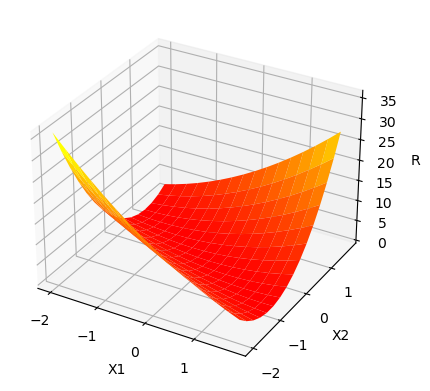

In [13]:
ax = plt.figure().add_subplot(projection='3d')
X1 = np.arange(-2, 2, 0.25)
X2 = np.arange(-2, 2, 0.25)
X1, X2 = np.meshgrid(X1, X2)
R = f(X1, X2)
ax.plot_surface(X1, X2, R, cmap='autumn')
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("R")
plt.show()

**Question** Calculez la valeur de $f$ en (2,4)

In [40]:
f(2, 4)

100

**Question** Fixez $\epsilon$ à 0.01 and calculez le gradient en (3, -2). Modifiez $\epsilon$ pour le rapprocher de 0...

In [9]:
esp = 0.01
x, y = 3, -2
(f(x+ esp, y)- f(x, y))/esp, (f(x, y +esp)- f(x, y))/esp

(-1.9899999999999585, -3.960000000000008)

In [11]:
esp = 0.000001
(f(x+ esp, y)- f(x, y))/esp, (f(x, y +esp)- f(x, y))/esp

(-1.9999990003016777, -3.999995999648398)

**Question** Faites la même chose pour un point où la pente est vraiment plus grande, positive ou négative. Ex en (0,1), (-2, -2)...

In [14]:
esp = 0.01
x, y = -2, -2
(f(x+ esp, y)- f(x, y))/esp, (f(x, y +esp)- f(x, y))/esp

(-11.989999999999412, -23.95999999999958)

# Dans python tout est objet...

In [16]:
a = 4
b = 5

**Question** Avec `dir` regardez les attributs et méthodes de l'objet `a`. Utilisez la méthode `__add__` pour effectuer `a+b`.

In [37]:
dir(a)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_op',
 '_prev',
 'data',
 'grad',
 'label']

In [19]:
a.__add__(b)

9

# Faire une classe pour stocker une valeur 

In [28]:
class Value:
    """ stores a single scalar value and its gradient """

    # this is executed when we create an object (instance) of this class
    def __init__(self, data):
        self.data = data   # the argument of the creation is kept as an attribute
     
    # this is how an object is represented (printed)
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # we define the add operator (+) and we create a new Value! 
    def __add__(self, other):
        return Value(self.data + other.data)
    
    def __mul__(self, other):
        return Value(self.data * other.data)

In [29]:
a = Value(4)
a

Value(data=4)

In [30]:
b = Value(5)
a + b

Value(data=9)

**Question** ajoutez l'opérateur `__mul__` (*). Définissez un `c` de valeur 3 et calculez a + b * c

In [31]:
a * b

Value(data=20)

# Arbre / graphe des expressions

In [83]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0   # by default gradients have a 0 value
        self._prev = set(_children) 
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    
    def __div__(self, other):
        return Value(self.data / other.data, (self, other), '/')
    
    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), '-')


In [61]:
a = Value(4)
b = Value(5) 
d = a + b
d._prev

{Value(data=4), Value(data=5)}

# Avec un dessin  

In [97]:
a = Value(2, label="a")
b = Value(-3, label="b") 
c = Value(10, label="c")
e = a * b ; e.label = "e"
d = e + c ; d.label = "d"
f = Value(-2, label="f")
L = d * f ; L.label="L"
L

Value(data=-8)

In [103]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

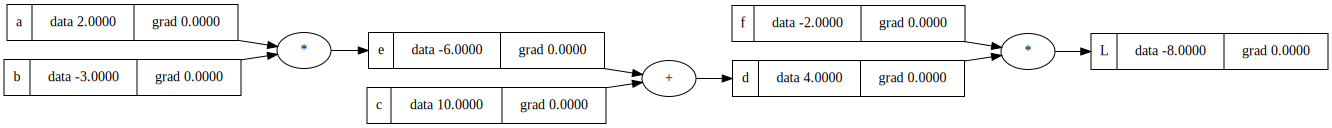

In [104]:
draw_dot(L)

# Calcul du gradient

**Question** Reproduire le calcul des dérivées partielles en faisant deux copies de l'expression de `L`. Essayez pour plusieurs variables. Regardez ce que cela donne aussi pour `L`.

In [92]:
def gradient():
    esp = 0.001
    a = Value(2, label="a")
    b = Value(-3, label="b") 
    c = Value(10, label="c")
    e = a * b ; e.label = "e"
    d = e + c ; d.label = "d"
    f = Value(-2, label="f")
    L = d * f ; L.label="L"
    func = L.data

    a = Value(2, label="a")
    b = Value(-3, label="b") 
    c = Value(10, label="c")
    e = a * b ; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2 + esp, label="f")
    L = d * f ; L.label="L"
    L1 = L.data

    a = Value(2, label="a")
    b = Value(-3, label="b") 
    c = Value(10, label="c")
    e = a * b ; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2 + esp, label="f")
    d.data += esp
    L = d * f ; L.label="L"
    L2 = L.data

    
    return (L1 - func) / esp, (L2 - func) / esp

gradient()

(3.9999999999995595, 2.0009999999990313)

**Question** Mémorisez le gradient de `L` par rapport à `L`, à `f` et à `d` dans les attributs `grad` correspondants et afficher l'arbre.

In [115]:
f.grad = -2
d.grad = 4

**Question** Au lieu de calculer le gradient de `L` par rapport aux autres variables de façon empirique, on applique la *chain rule* pour évaluer le gradient par rapport à `c` et à  `e`

D'après [Wikipedia](https://en.wikipedia.org/wiki/Chain_rule) : _If a variable $z$ depends on the variable $y$, which itself depends on the variable $x$ (that is, $y$ and $z$ are dependent variables), then $z$ depends on $x$ as well, via the intermediate variable $y$. In this case, the chain rule is expressed as_ $\displaystyle {\frac {dz}{dx}}={\frac {dz}{dy}}\cdot {\frac {dy}{dx}}$. 

 _knowing the instantaneous rate of change of z relative to y and that of y relative to x allows one to calculate the instantaneous rate of change of z relative to x as the product of the two rates of change_.

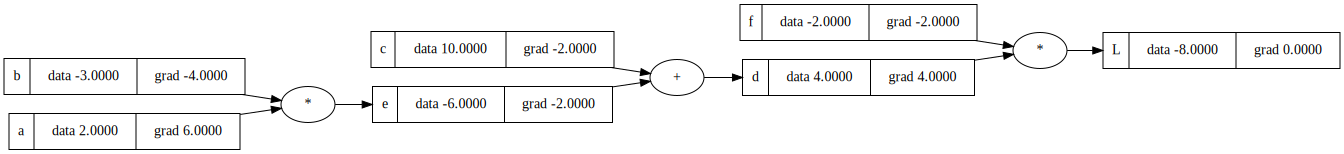

In [116]:
c.grad = -2
e.grad = -2
draw_dot(L)

**Question** Puis par rapport à `a` et `b`...

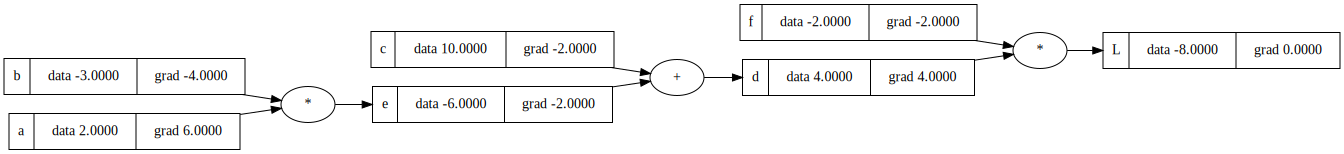

In [117]:
a.grad = 6
b.grad = -4
draw_dot(L)

**Question** On peut vérifier que si on change la valeur des variables feuille de cet arbre dans la direction opposée de leur gradient associé, on doit baisser la valeur de L. Appliquez un pas d'apprentissage de 0.01 et observez le résultat en recalculant  : `e = a * b ; d = e + c  ; L = d * f`.

# Avec une méthode dans la classe...

Grâce à la chain rule, on comprend qu'on peut calculer tous les gradients de  `L` par rapport à toute variable dans le graphe en procédant localement, c'est-à-dire en utilisant la valeur du gradient des parents d'un noeud. On ajoute une fonction qui réalise le calcul pour tout noeud en remarquant :

- La racine n'a pas de parent, la fonction gradient ne fait rien pour ce noeud
- pour un noeud `+`, le gradient des enfants est celui du parent.
- pour un noeud `*`, c'est le gradient du père multiplié par la valeur du frère

On implante cela dans une méthode `backward`

In [121]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children) # keep the set of children of this node
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        # we create and add a backward method dynamically
        def _backward():
            self.grad = out.grad
            other.grad = out.grad
        out._backward = _backward
        return out 

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out 
        

In [122]:
a = Value(2, label="a")
b = Value(-3, label="b") 
c = Value(10, label="c")
e = a * b ; e.label = "e"
d = e + c ; d.label = "d"
f = Value(-2, label="f")
L = d * f ; L.label="L"

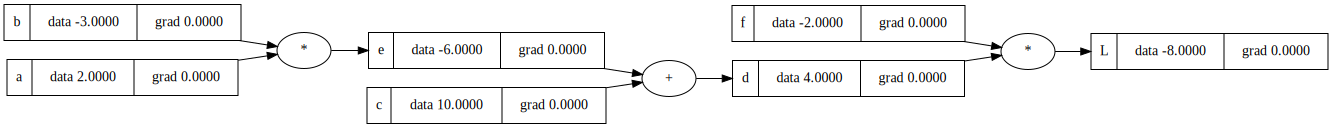

In [123]:
draw_dot(L)

**Question** On peut fixer la valeur du gradient de `L` par rapport à `L` et appeler la méthode `backward` dans le bon ordre... Affichez l'arbre à chaque fois pour vérifier.

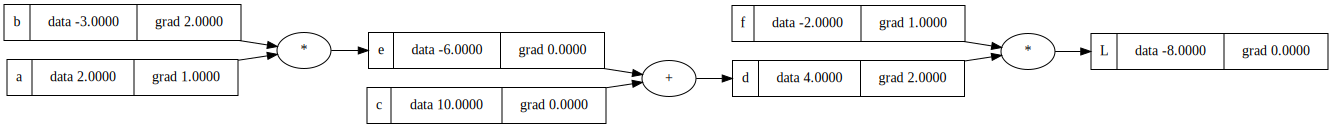

In [127]:
draw_dot(L)
f.grad = 1
draw_dot(L)
d.grad = 2
draw_dot(L)